In [13]:
%run ../Python/PageHD1.py
%matplotlib notebook
import scipy.sparse

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def pop_f(R, tuning, weights, f):
    return np.inner(R.T, weights@f(tuning))

def compute_HD(R, tuning, weights=None):
    if weights is None:
        weights = np.identity(tuning.size)
    HD_sin = pop_f(R, tuning, weights, np.sin)
    HD_cos = pop_f(R, tuning, weights, np.cos)
    HD = np.arctan(HD_sin / HD_cos)
    HD[HD_cos < 0] += np.pi
    HD[(HD_sin < 0) & (HD_cos > 0)] += 2*np.pi
    return HD

def read_map(prefix, with_distal=True):
    import csv
    proximal_objs = []
    distal_objs = None
    with open(prefix + '/Agent/map.info', newline='\n') as csvfile:
        mapreader = csv.reader(csvfile, delimiter=',')
        i = 0
        for row in mapreader:
            if i == 0:
                bound_x, bound_y = row
                bound_x, bound_y = float(bound_x), float(bound_y)
            elif with_distal and i == 1:
                distal_objs = np.array(row, dtype=float)
            else:
                proximal_objs.append(list(row))
            i += 1
    return (bound_x, bound_y), distal_objs, np.array(proximal_objs, dtype=float)

In [15]:
#outdir = '../../rbfopt/HD_VIS_out'
outdir = '../Build/pandapics/HD_out'

N_VIS, N_HD, N_AHVxHD, N_AHV, N_FV, N_PLACE, N_PLACExFVxHD = 0, 0, 0, 0, 0, 0, 0

if False:
    bounds, distal_objects, proximal_objects = read_map(outdir, with_distal=True)
    bound_x = bounds[0]
    bound_y = bounds[1]

    num_objects = distal_objects.shape[0] + proximal_objects.shape[0]

    N_VIS = num_objects * 100
    N_HD = 300
    N_AHVxHD = 3 * N_HD
    N_AHV = 3  * 50
    N_FV = 2 * 50
    N_PLACE = N_HD
    N_PLACExFVxHD = 3 * 2 * N_PLACE

N_VIS = 400
N_HD = 400
N_AHVxHD = 800
N_AHV = 100

In [22]:
rate_buf_ival = 2**-6
weights_buf_ival = 10.0

test_start_t = 1200 # 355
test_stop_t = test_start_t + 50 # 1022
test_start_i = int(test_start_t/rate_buf_ival)
test_stop_i = int(test_stop_t/rate_buf_ival)

agent_hist = read_rates(outdir, 'Agent', 3, fname='history.bin')
fig, ax = plt.subplots()
ax.set_xlim(-bound_x, bound_x)
ax.set_ylim(-bound_x, bound_y)
ax.scatter(proximal_objects[:, 0], proximal_objects[:, 1])
ax.plot(agent_hist[0][test_start_i:test_stop_i], agent_hist[1][test_start_i:test_stop_i])
ax.plot()

fig, ax = plt.subplots(2)
ax = ax.flatten()
ax[0].plot(agent_hist[0][test_start_i:test_stop_i])
ax[0].plot(agent_hist[1][test_start_i:test_stop_i])
ax[1].plot(agent_hist[2][test_start_i:test_stop_i])

R_AHV = read_rates(outdir, 'AHV', N_AHV)
print(np.mean(R_AHV[[25, 75, 125], :], 1))

FileNotFoundError: [Errno 2] No such file or directory: '../Build/pandapics/HD_out/Agent/history.bin'

<IPython.core.display.Javascript object>


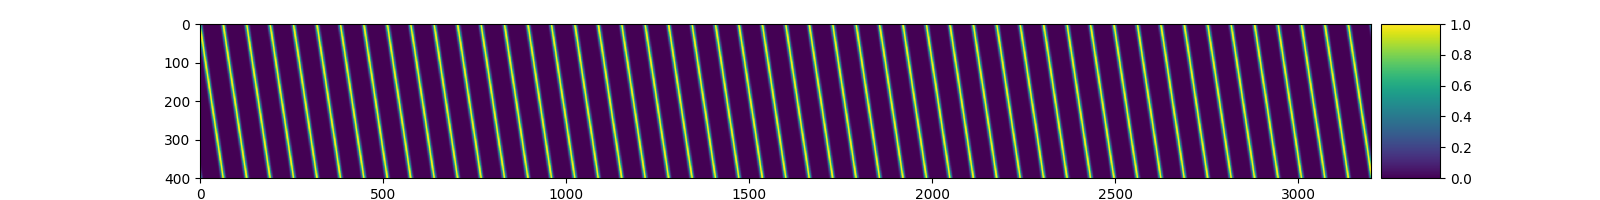

Sparsity: 0.139257


In [415]:
R_VIS = read_rates(outdir, 'VIS', N_VIS)
imshow(R_VIS[:, test_start_i:test_stop_i])
print('Sparsity: %f' % (np.mean(np.sum(R_VIS, 0)) / N_VIS))

<IPython.core.display.Javascript object>


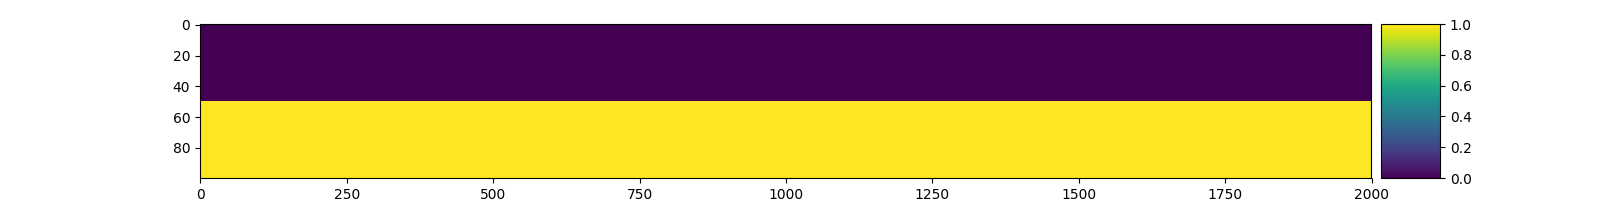

Sparsity: 0.500000


In [416]:
R_AHV = read_rates(outdir, 'AHV', N_AHV)
imshow(R_AHV[:, -2000:])
print('Sparsity: %f' % (np.mean(np.sum(R_AHV, 0)) / N_AHV))

<IPython.core.display.Javascript object>


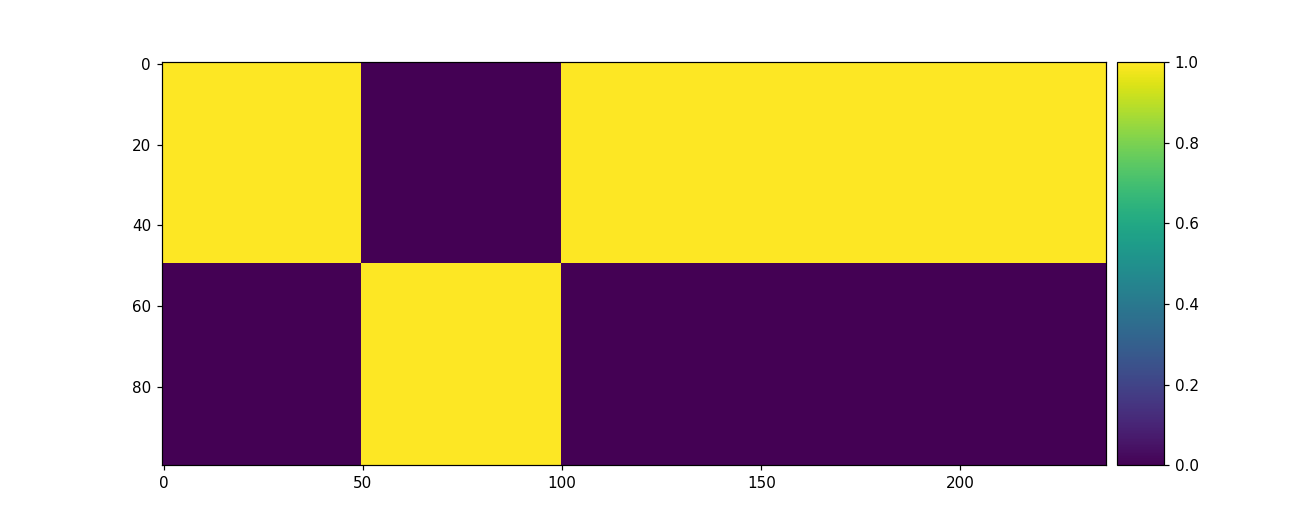

Sparsity: 0.500000


In [21]:
R_FV = read_rates(outdir, 'FV', N_FV)
imshow(R_FV[:, -2000:])
print('Sparsity: %f' % (np.mean(np.sum(R_FV, 0)) / N_FV))

/home/toby/Virtual/virtualenv/oftnai/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


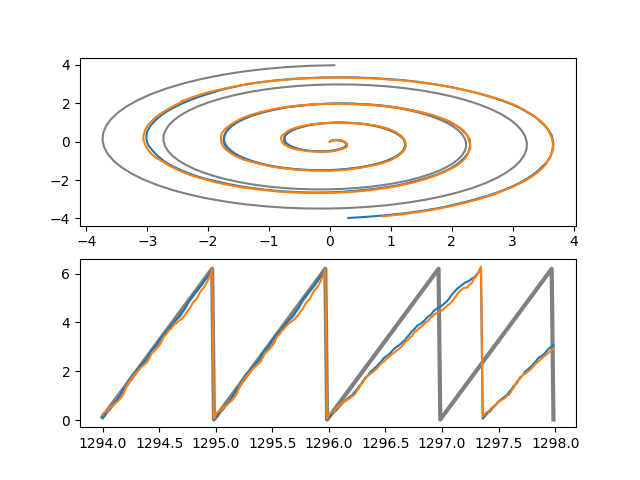

3.11417396676
3.08950367584
0.0225361864078


In [838]:
rate_buf_ival = 2**-6
weights_buf_ival = 2.0

test_start_t = 1294
test_stop_t = test_start_t + 4
test_start_i = int(test_start_t/rate_buf_ival)
test_stop_i = int(test_stop_t/rate_buf_ival)

num_objects = 1

N_VIS_per_obj = (N_VIS // num_objects)
VIS_tuning = 2 * np.pi * np.arange(N_VIS_per_obj, dtype=float) / N_VIS_per_obj
VIS_tuning = np.concatenate([VIS_tuning] * num_objects)
VIS_in_tuning = VIS_tuning.copy()
VIS_in_tuning[(N_VIS_per_obj*distal_objects.shape[0]):] = 0

W_VIS_HD = read_weights(outdir, 'HD', 'VIS', N_VIS, N_HD)[int(test_start_t/weights_buf_ival)-1]
W_HD_AHVxHD = read_weights(outdir, 'AHVxHD', 'HD', N_HD, N_AHVxHD)[int(test_start_t/weights_buf_ival)-1]
R_HD = read_rates(outdir, 'HD', N_HD)
R_AHVxHD = read_rates(outdir, 'AHVxHD', N_AHVxHD)
R_VIS_in = read_rates(outdir, 'VIS', N_VIS)
R_VIS = read_rates(outdir, 'VIS_cf', N_VIS)

HD_true = compute_HD(R_VIS, VIS_tuning)
#HD_true = read_rates(outdir, 'Agent', 3, fname='history.bin')[2]
HD_in = compute_HD(R_VIS_in, VIS_in_tuning)
HD_HD = compute_HD(R_HD, VIS_tuning, W_VIS_HD)
HD_AHVxHD = compute_HD(R_AHVxHD, VIS_tuning, W_HD_AHVxHD@W_VIS_HD)

fig, ax = plt.subplots(2) #3)
ax = ax.flatten()
time = (np.arange(test_start_i, test_stop_i) - test_start_i) * rate_buf_ival
ax[0].plot(time*(np.sin(HD_true)[test_start_i:test_stop_i]),
           time*(np.cos(HD_true)[test_start_i:test_stop_i]), color='gray')
#ax[0].plot(time*(np.sin(HD_in)[test_start_i:test_stop_i]),
#           time*(np.cos(HD_in)[test_start_i:test_stop_i]))
ax[0].plot(time*(np.sin(HD_HD)[test_start_i:test_stop_i]),
           time*(np.cos(HD_HD)[test_start_i:test_stop_i]))
ax[0].plot(time*(np.sin(HD_AHVxHD)[test_start_i:test_stop_i]),
           time*(np.cos(HD_AHVxHD)[test_start_i:test_stop_i]))

ax[1].plot(time+test_start_t, HD_true[test_start_i:test_stop_i], lw=3, color='gray')
#ax[1].plot(time+test_start_t, HD_in[test_start_i:test_stop_i])
ax[1].plot(time+test_start_t, HD_HD[test_start_i:test_stop_i])
ax[1].plot(time+test_start_t, HD_AHVxHD[test_start_i:test_stop_i])

#min_len = np.min((len(HD_true), len(HD_HD)))
#ax[2].plot(moving_average((HD_true[test_start_i:test_stop_i]-HD_HD[test_start_i:test_stop_i])**2, 10))

print(np.mean((HD_true[test_start_i:test_stop_i]-HD_HD[test_start_i:test_stop_i])**2))
print(np.mean((HD_true[test_start_i:test_stop_i]-HD_AHVxHD[test_start_i:test_stop_i])**2))
print(np.mean((HD_HD[test_start_i:test_stop_i]-HD_AHVxHD[test_start_i:test_stop_i])**2))
#TODO: plot moving average of the error

<IPython.core.display.Javascript object>


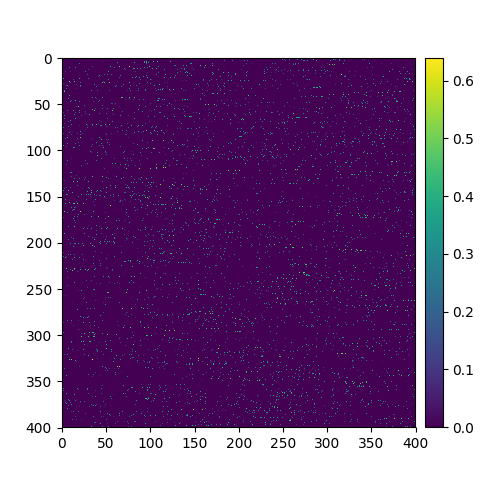

<IPython.core.display.Javascript object>


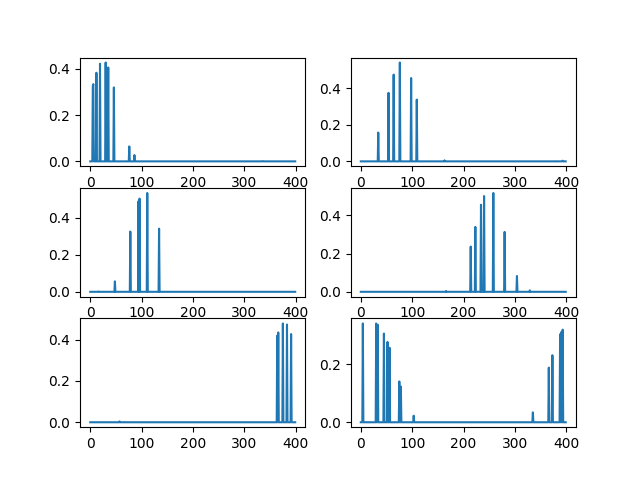

0.00818515 nan
0.166534 nan


/home/toby/Virtual/virtualenv/oftnai/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/toby/Virtual/virtualenv/oftnai/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [16]:
num_objects = 1
W_VIS_HD = read_weights(outdir, 'HD', 'VIS', N_VIS, N_HD)[-1]# - read_weights(outdir, 'HD', 'VIS', N_VIS, N_HD)[-10]
#VIS_tuning = 2 * np.pi * np.arange(N_VIS, dtype=float) / N_VIS
VIS_tuning = 2 * np.pi * np.arange((N_VIS // num_objects), dtype=float) / (N_VIS // num_objects)
VIS_tuning = np.concatenate([VIS_tuning] * num_objects)
HD_tuning = W_VIS_HD @ VIS_tuning
#W_VIS_HD_idx = np.indices((W_VIS_HD.shape[1],))[0] + 1
W_VIS_HD_idx = np.argsort(HD_tuning) # np.sum(W_VIS_HD * W_VIS_HD_idx, 1))[::-1]
W_VIS_HD_idx = np.arange(N_HD)
imshow(W_VIS_HD[W_VIS_HD_idx])
fig, ax = plt.subplots(3,2)
ax = ax.flatten()
ax[0].plot(W_VIS_HD[W_VIS_HD_idx[1]])
ax[1].plot(W_VIS_HD[10])
ax[2].plot(W_VIS_HD[151])
ax[3].plot(W_VIS_HD[202])
ax[4].plot(W_VIS_HD[W_VIS_HD_idx[-10]])
ax[5].plot(W_VIS_HD[W_VIS_HD_idx[-1]])

W_dist_HD = W_VIS_HD[:,:800]
W_prox_HD = W_VIS_HD[:,800:]
print(np.mean(W_dist_HD),
      np.mean(W_prox_HD))
print(np.mean(W_dist_HD[W_dist_HD>0]),
      np.mean(W_prox_HD[W_prox_HD>0]))

<IPython.core.display.Javascript object>


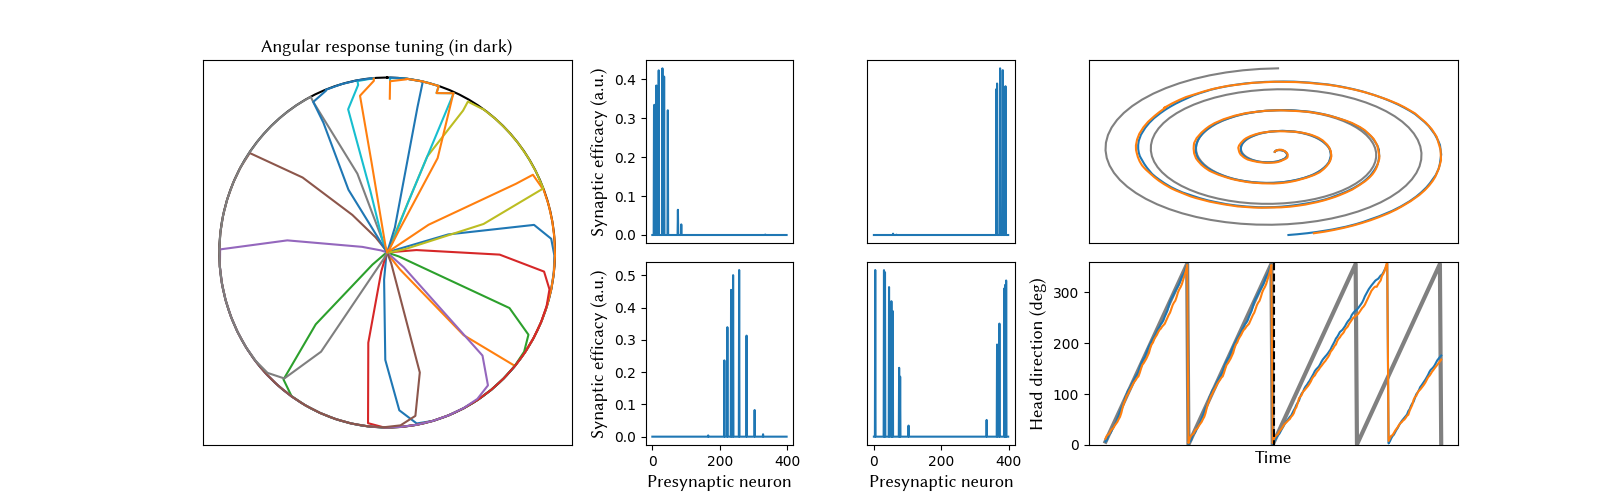

[245, 159, 110, 381, 397, 382, 34, 392, 153, 344, 78, 214]


In [891]:
#HD_sparsity = np.mean(np.sum(R_HD[:, test_start_i:test_stop_i], 0)) / N_HD
#J = np.random.choice(np.arange(N_HD), 3, replace=False) # int(N_HD*HD_sparsity)

fig = plt.figure(figsize=(16.2, 5))
plt.subplots_adjust(hspace=0.1, wspace=0.5)
ax0 = plt.subplot2grid((2,6), (0,0), rowspan=2, colspan=2)
#ax_frame = plt.subplot2grid((2,6), (0,2), rowspan=2, colspan=2)#, frameon=False)
ax1 = plt.subplot2grid((2,6), (0,2))#, sharex=ax_frame)
ax2 = plt.subplot2grid((2,6), (1,2), sharex=ax1)
ax3 = plt.subplot2grid((2,6), (0,3), sharex=ax2)
ax4 = plt.subplot2grid((2,6), (1,3), sharex=ax3)
ax5 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax6 = plt.subplot2grid((2,6), (1,4), colspan=2)

J = [245, 159, 110, 381, 397, 382, 34, 392, 153, 344, 78, 214]
#J = [78]
print(J)
#_R_HD = R_HD[:, test_start_i:test_stop_i].copy()
#__theta_tmp = HD_true[test_start_i:test_stop_i].copy()
#__theta_tmp = sorted(__theta_tmp)
ax0.plot(np.sin(np.linspace(0, 2*np.pi, 100)), np.cos(np.linspace(0, 2*np.pi, 100)), color='black')
for j in J:
    _r_tmp = _R_HD[j]#[np.argsort(_theta_tmp)]
    ax0.plot(_r_tmp*(np.sin(__theta_tmp)),
            _r_tmp*(np.cos(__theta_tmp)), '-')

ax1.plot(W_VIS_HD[W_VIS_HD_idx[1]])
ax2.plot(W_VIS_HD[202])
ax3.plot(W_VIS_HD[W_VIS_HD_idx[-10]])
ax4.plot(W_VIS_HD[W_VIS_HD_idx[-1]])

time = (np.arange(test_start_i, test_stop_i) - test_start_i) * rate_buf_ival
ax5.plot(time*(np.sin(HD_true)[test_start_i:test_stop_i]),
         time*(np.cos(HD_true)[test_start_i:test_stop_i]), color='gray')
ax5.plot(time*(np.sin(HD_HD)[test_start_i:test_stop_i]),
         time*(np.cos(HD_HD)[test_start_i:test_stop_i]))
ax5.plot(time*(np.sin(HD_AHVxHD)[test_start_i:test_stop_i]),
         time*(np.cos(HD_AHVxHD)[test_start_i:test_stop_i]))

ax6.plot(time+test_start_t, HD_true[test_start_i:test_stop_i]*180/np.pi, lw=3, color='gray')
ax6.plot(time+test_start_t, HD_HD[test_start_i:test_stop_i]*180/np.pi)
ax6.plot(time+test_start_t, HD_AHVxHD[test_start_i:test_stop_i]*180/np.pi)
ax6.plot([1296,1296],[-5,365], '--', color='black')
ax6.set_ylim(0, 360)

import matplotlib.font_manager as fm
prop = fm.FontProperties(fname='/usr/share/fonts/opentype/linux-libertine/LinBiolinum_R.otf')

ax0.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
ax1.tick_params(bottom='off', labelbottom='off')
#ax2.tick_params(bottom='off', labelbottom='off')
ax3.tick_params(left='off', labelleft='off', bottom='off', labelbottom='off')
ax4.tick_params(left='off', labelleft='off')#, bottom='off', labelbottom='off')

ax0.set_title('Angular response tuning (in dark)', fontproperties=prop, size=13)

ax1.set_ylabel('Synaptic efficacy (a.u.)', fontproperties=prop, size=13)
ax2.set_ylabel('Synaptic efficacy (a.u.)', fontproperties=prop, size=13)

ax2.set_xlabel('Presynaptic neuron', fontproperties=prop, size=13)
ax4.set_xlabel('Presynaptic neuron', fontproperties=prop, size=13)

ax5.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
ax6.tick_params(bottom='off', labelbottom='off')

ax6.set_xlabel('Time', fontproperties=prop, size=13)
ax6.set_ylabel('Head direction (deg)', fontproperties=prop, size=13)

#ax0.set_ylabel(r'Normalised firing rate', fontproperties=prop, size=14)
fig.savefig('hd-pi.png', dpi=300, edgecolor='none', transparent=True)   

<IPython.core.display.Javascript object>


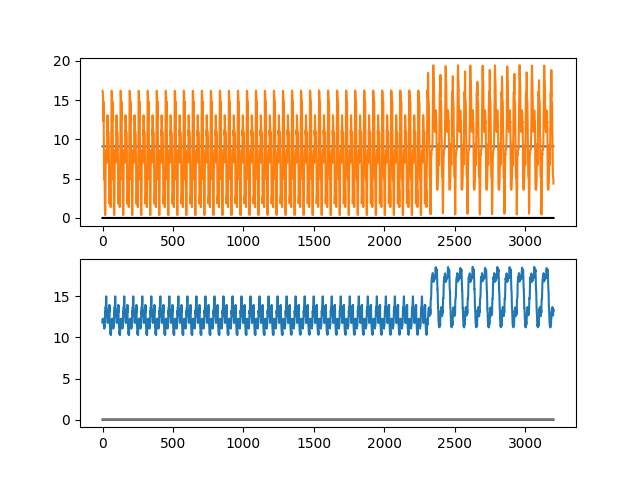

99 28
176.265 257.276


In [19]:
#j = 40

j_HD = np.random.randint(0, np.min(N_HD)) # j
j_AHVxHD = np.random.randint(0, np.min(N_AHVxHD)) # j

start, stop = test_start_i, test_stop_i

fig, ax = plt.subplots(2)

R_AHV = read_rates(outdir, 'AHV', N_AHV)[:, start:stop]

R_AHVxHD = np.array(read_rates(outdir, 'AHVxHD', N_AHVxHD)[:, start:stop])
H_AHV_AHVxHD = accumulate_activation(outdir, 'AHVxHD', ['AHV'], N_AHVxHD, slice(start, stop))
H_HD_AHVxHD = accumulate_activation(outdir, 'AHVxHD', ['HD'], N_AHVxHD, slice(start, stop))
H_max_AHVxHD_j = np.max(np.sum(np.abs([H_AHV_AHVxHD[j_AHVxHD], H_HD_AHVxHD[j_AHVxHD]]), 0))
R_AHVxHD_j_scaled = R_AHVxHD[j_AHVxHD]*H_max_AHVxHD_j
ax[0].plot(R_AHVxHD_j_scaled, color='black')
ax[0].plot(H_AHV_AHVxHD[j_AHVxHD])
ax[0].plot(H_HD_AHVxHD[j_AHVxHD])

R_HD = read_rates(outdir, 'HD', N_HD)[:, start:stop]
H_AHVxHD_HD = accumulate_activation(outdir, 'HD', ['AHVxHD'], N_HD, slice(start, stop))
H_max_HD_j = np.max(H_AHVxHD_HD[j_HD])
R_HD_j_scaled = R_HD[j_HD]*H_max_HD_j
ax[1].plot(R_HD_j_scaled, color='black')
ax[1].plot(H_AHVxHD_HD[j_HD])
ax[1].plot(R_AHV[0]*H_max_HD_j, color='gray', lw=1)

print(j_AHVxHD, j_HD)
print(np.mean((R_HD_j_scaled-H_AHVxHD_HD[j_HD])**2),
      np.mean((R_AHVxHD_j_scaled-H_AHV_AHVxHD[j_HD]-H_HD_AHVxHD[j_HD])**2))
#TODO: plot moving average of the error terms

<IPython.core.display.Javascript object>


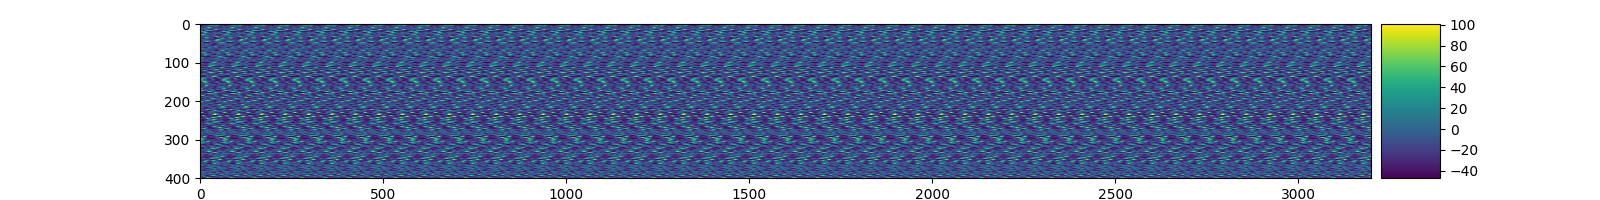

<IPython.core.display.Javascript object>


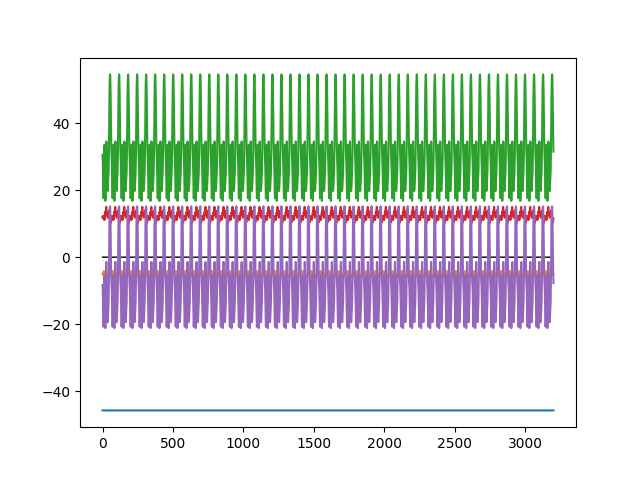

<IPython.core.display.Javascript object>


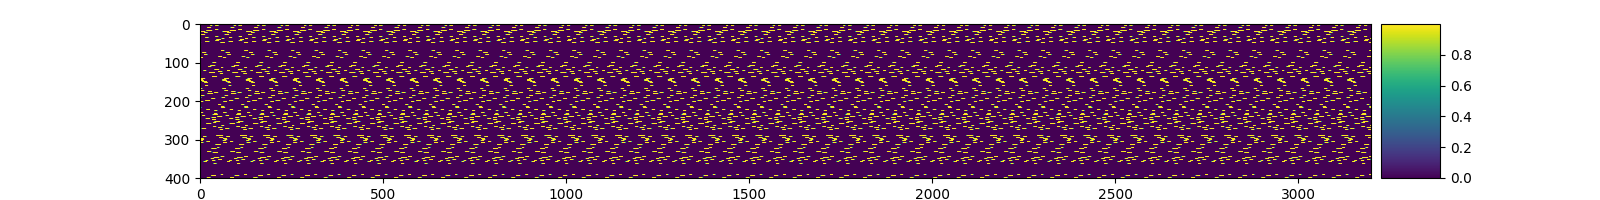

<IPython.core.display.Javascript object>


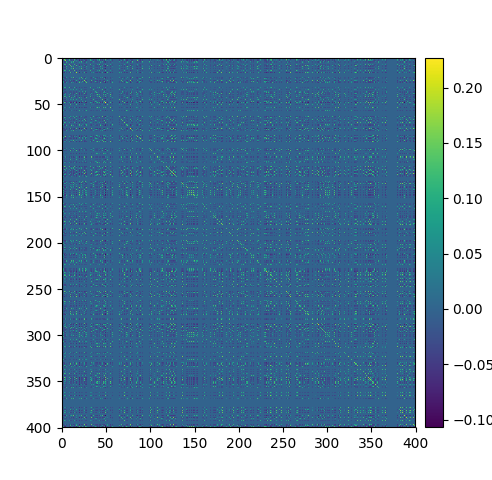

<IPython.core.display.Javascript object>


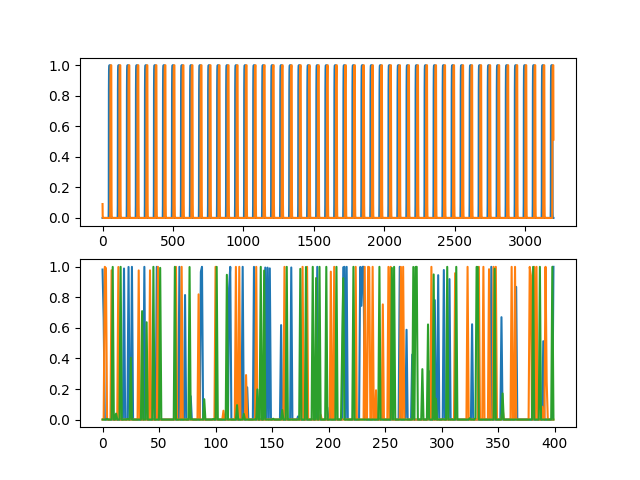

-5.11434 -45.7001 29.5297 13.0717
Sparsity: 0.094710


In [23]:
start, stop = test_start_i, test_stop_i

R_AHV = read_rates(outdir, 'AHV', N_AHV)[:, start:stop]
H_VIS_HD_INH = accumulate_activation(outdir, 'HD', ['VIS'], N_HD, slice(start, stop), INH=True)
H_HD_HD_INH = accumulate_activation(outdir, 'HD', ['HD'], N_HD, slice(start, stop), INH=True) # 'AHVxHD'
H_VIS_HD = accumulate_activation(outdir, 'HD', ['VIS'], N_HD, slice(start, stop))
H_AHVxHD_HD = accumulate_activation(outdir, 'HD', ['AHVxHD'], N_HD, slice(start, stop))
imshow((H_VIS_HD_INH + H_HD_HD_INH + H_VIS_HD + H_AHVxHD_HD)[W_VIS_HD_idx])
fig, ax = plt.subplots()
# blue, orange, green, red, purple
j = j_HD # 40
ax.plot(R_AHV[0]*np.min(H_VIS_HD_INH), color='black', lw=1)
ax.plot(H_VIS_HD_INH[j])
ax.plot(H_HD_HD_INH[j])
ax.plot(H_VIS_HD[j])
ax.plot(H_AHVxHD_HD[j])
ax.plot(H_VIS_HD_INH[j] + H_HD_HD_INH[j] + H_VIS_HD[j] + H_AHVxHD_HD[j])

R_HD = read_rates(outdir, 'HD', N_HD)[:, start:stop]
imshow(R_HD[W_VIS_HD_idx])
imshow(np.cov(R_HD[W_VIS_HD_idx]))
fig, ax = plt.subplots(2)
ax = ax.flatten()
ax[0].plot(R_HD[40])
ax[0].plot(R_HD[W_VIS_HD_idx[-10]])
ax[1].plot(R_HD[W_VIS_HD_idx][:, -1])
ax[1].plot(R_HD[W_VIS_HD_idx][:, -21])
ax[1].plot(R_HD[W_VIS_HD_idx][:, -41])

print(np.mean(H_HD_HD_INH), np.mean(H_VIS_HD_INH), np.mean(H_VIS_HD), np.mean(H_AHVxHD_HD))
print('Sparsity: %f' % (np.mean(R_HD)))
#print(np.mean(read_rates(outdir, 'HD', N_HD), 0))

<IPython.core.display.Javascript object>


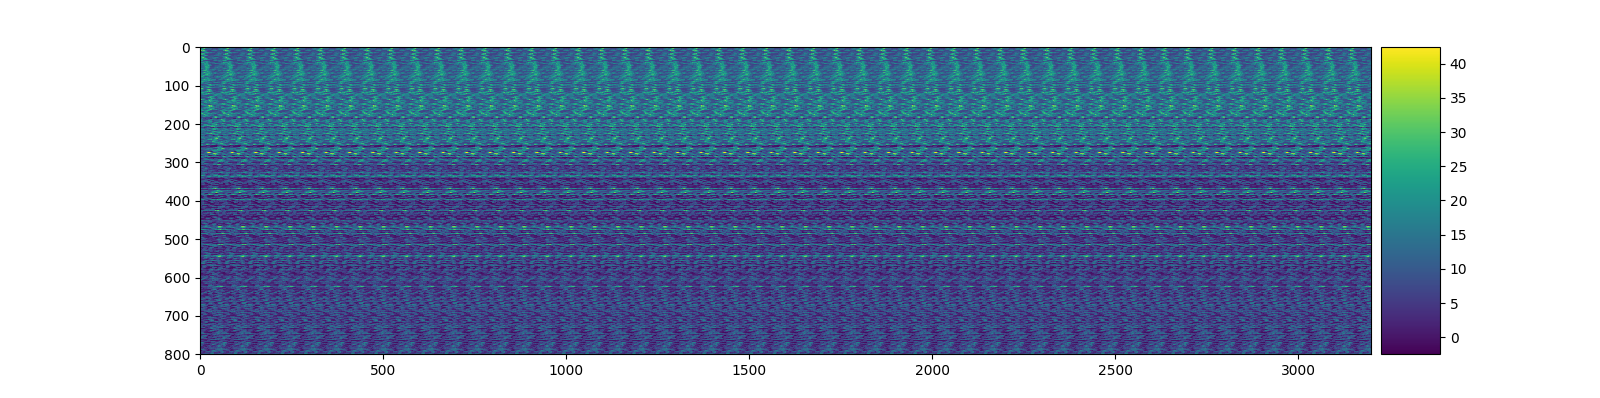

<IPython.core.display.Javascript object>


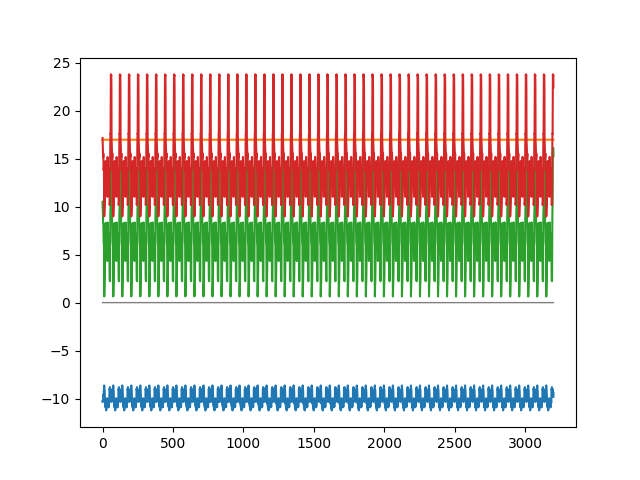

<IPython.core.display.Javascript object>


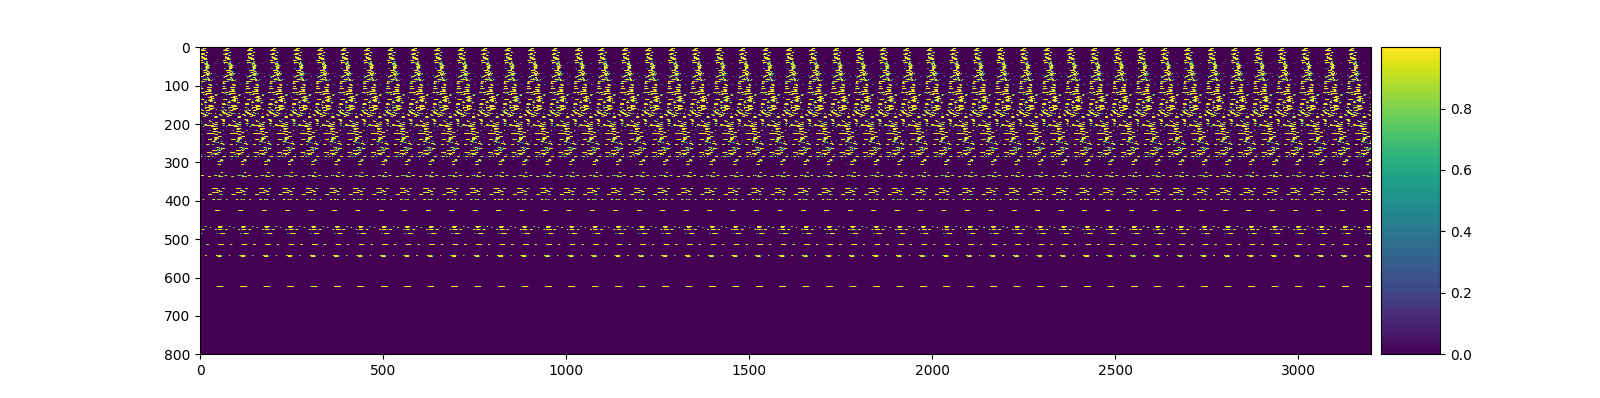

<IPython.core.display.Javascript object>


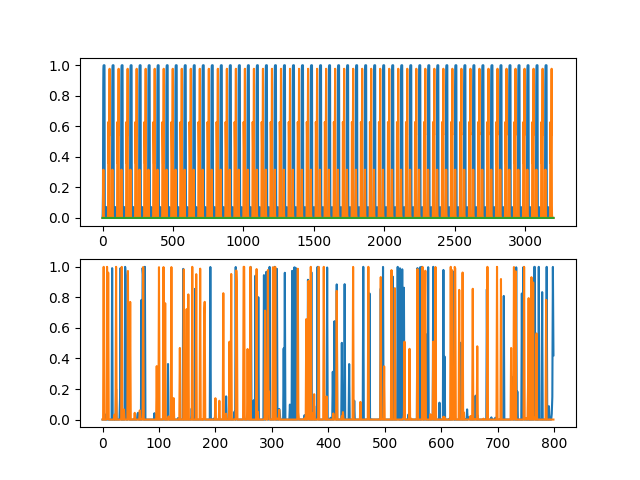

-9.92792 13.1475 6.66905
Sparsity: 0.082733


In [24]:
start, stop = test_start_i, test_stop_i # -1000, -1

R_AHV = read_rates(outdir, 'AHV', N_AHV)[:, start:stop]

H_AHVxHD_INH = accumulate_activation(outdir, 'AHVxHD', ['AHVxHD'], N_AHVxHD, slice(start, stop), INH=True) # 'HD'
H_AHV_AHVxHD = accumulate_activation(outdir, 'AHVxHD', ['AHV'], N_AHVxHD, slice(start, stop))
H_HD_AHVxHD = accumulate_activation(outdir, 'AHVxHD', ['HD'], N_AHVxHD, slice(start, stop))
H_AHVxHD = H_AHVxHD_INH + H_HD_AHVxHD + H_AHV_AHVxHD
imshow(H_AHVxHD[W_idx_s])

# blue, orange, green, red, purple
fig, ax = plt.subplots()
j = 40
ax.plot(R_AHV[j]*np.min(H_AHVxHD_INH[j]), color='gray', lw=1)
ax.plot(H_AHVxHD_INH[j])
ax.plot(H_AHV_AHVxHD[j])
ax.plot(H_HD_AHVxHD[j])
ax.plot(H_AHVxHD[j])

R_AHVxHD = np.array(read_rates(outdir, 'AHVxHD', N_AHVxHD)[:, start:stop])
imshow(R_AHVxHD[W_idx_s])
fig, ax = plt.subplots(2)
ax = ax.flatten()
ax[0].plot(R_AHVxHD[W_idx_s[10]])
ax[0].plot(R_AHVxHD[W_idx_s[250]])
ax[0].plot(R_AHVxHD[W_idx_s[500]])
ax[1].plot(R_AHVxHD[:, -1])
ax[1].plot(R_AHVxHD[:, -17])

print(np.mean(H_AHVxHD_INH), np.mean(H_AHV_AHVxHD), np.mean(H_HD_AHVxHD))
print('Sparsity: %f' % (np.mean(np.sum(R_AHVxHD, 0)) / N_AHVxHD))

<IPython.core.display.Javascript object>


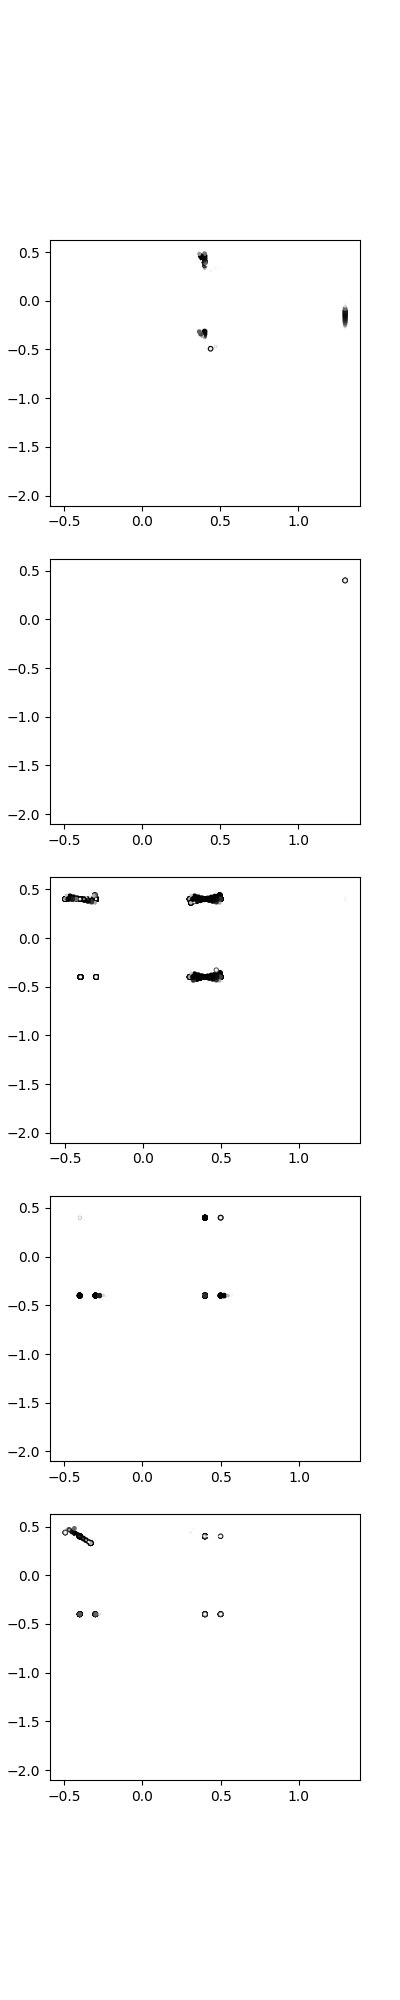

/home/toby/Virtual/virtualenv/oftnai/lib/python3.5/site-packages/matplotlib/collections.py:865: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


In [410]:
test_start_t = 2000
test_stop_t = test_start_t + 50
test_start_i = int(test_start_t/rate_buf_ival)
test_stop_i = int(test_stop_t/rate_buf_ival)
start, stop = test_start_i, test_stop_i # -10000, -1
step = 1
agent_hist = read_rates(outdir, 'Agent', 3, fname='history.bin')
X, Y = agent_hist[0][start:stop:step], agent_hist[1][start:stop:step]
#J = [ 7,  50,  60,
#     90, 100, 170,
#    195, 226, 283]
J = np.random.choice(np.arange(N_PLACE), 5, replace=False)
R_PLACE = read_rates(outdir, 'PLACE', N_PLACE)[:, start:stop:step]
fig, ax = plt.subplots(len(J), figsize=(4,len(J)*4))
ax = ax.flatten()
for i, j in enumerate(J):
    ax[i].scatter(X, Y, 10*R_PLACE[j]/np.max(R_PLACE[j]), R_PLACE[j], cmap=plt.get_cmap('binary'))

/home/toby/Virtual/virtualenv/oftnai/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


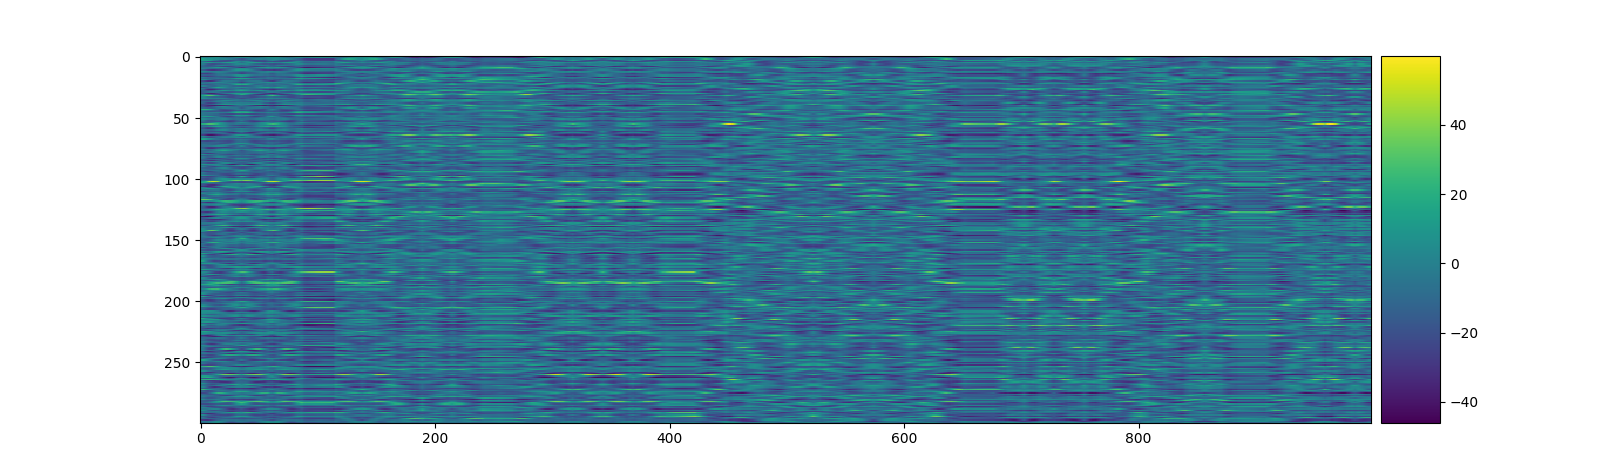

<IPython.core.display.Javascript object>


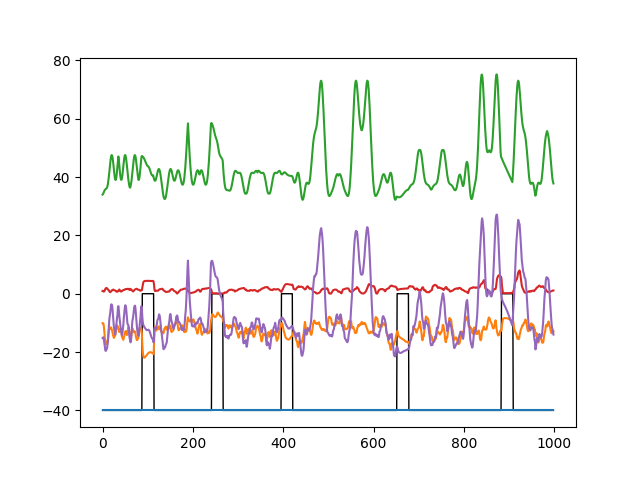

<IPython.core.display.Javascript object>


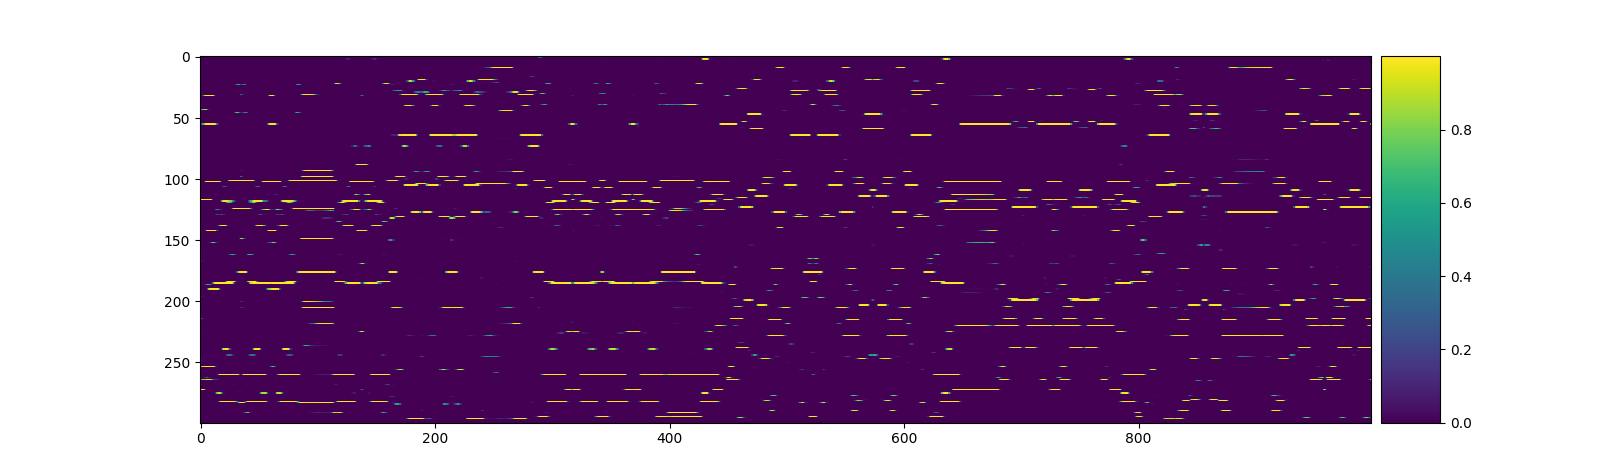

<IPython.core.display.Javascript object>


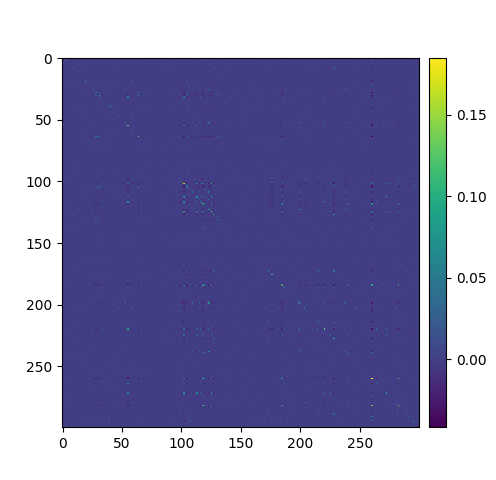

<IPython.core.display.Javascript object>


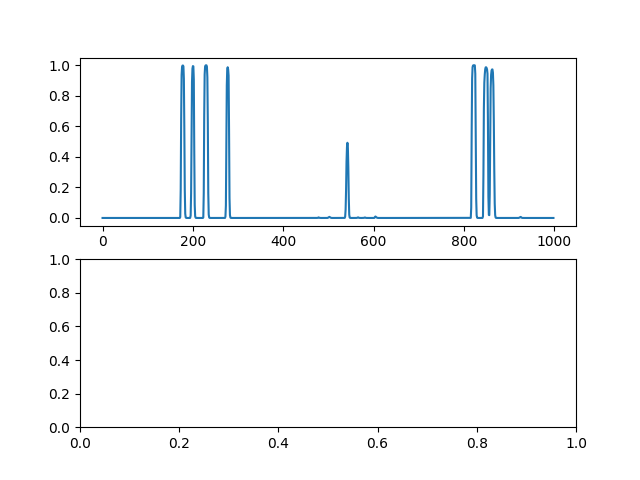

-12.5951 -40.0 43.0954 1.61735
Sparsity: 0.020995


In [349]:
start, stop = -1000, -1 # test_start_i, test_stop_i

R_HD = read_rates(outdir, 'HD', N_HD)[:, start:stop]
R_FV = read_rates(outdir, 'FV', N_FV)[:, start:stop]
H_VIS_PLACE_INH = accumulate_activation(outdir, 'PLACE', ['VIS'], N_PLACE, slice(start, stop), INH=True)
H_PLACE_PLACE_INH = accumulate_activation(outdir, 'PLACE', ['PLACE'], N_PLACE, slice(start, stop), INH=True) # 'AHVxHD'
H_VIS_PLACE = accumulate_activation(outdir, 'PLACE', ['VIS'], N_PLACE, slice(start, stop))
H_PLACExFVxHD_PLACE = accumulate_activation(outdir, 'PLACE', ['PLACExFVxHD'], N_PLACE, slice(start, stop))
imshow((H_VIS_PLACE_INH + H_PLACE_PLACE_INH + H_VIS_PLACE + H_PLACExFVxHD_PLACE)) #[W_VIS_PLACE_idx])
fig, ax = plt.subplots()
# blue, orange, green, red, purple
j = j_HD # 40
ax.plot(R_FV[0]*np.min(H_VIS_PLACE_INH), color='black', lw=1)
ax.plot(H_VIS_PLACE_INH[j])
ax.plot(H_PLACE_PLACE_INH[j])
ax.plot(H_VIS_PLACE[j])
ax.plot(H_PLACExFVxHD_PLACE[j])
ax.plot(H_VIS_PLACE_INH[j] + H_PLACE_PLACE_INH[j] + H_VIS_PLACE[j] + H_PLACExFVxHD_PLACE[j])

R_PLACE = read_rates(outdir, 'PLACE', N_PLACE)[:, start:stop]
imshow(R_PLACE) # [W_VIS_HD_idx])
imshow(np.cov(R_PLACE)) # [W_VIS_HD_idx]))
fig, ax = plt.subplots(2)
ax = ax.flatten()
ax[0].plot(R_PLACE[40])
#ax[0].plot(R_HD[W_VIS_HD_idx[-10]])
#ax[1].plot(R_HD[W_VIS_HD_idx][:, -1])
#ax[1].plot(R_HD[W_VIS_HD_idx][:, -21])
#ax[1].plot(R_HD[W_VIS_HD_idx][:, -41])

print(np.mean(H_PLACE_PLACE_INH), np.mean(H_VIS_PLACE_INH), np.mean(H_VIS_PLACE), np.mean(H_PLACExFVxHD_PLACE))
print('Sparsity: %f' % (np.mean(R_PLACE)))
#print(np.mean(read_rates(outdir, 'HD', N_HD), 0))

/home/toby/Virtual/virtualenv/oftnai/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


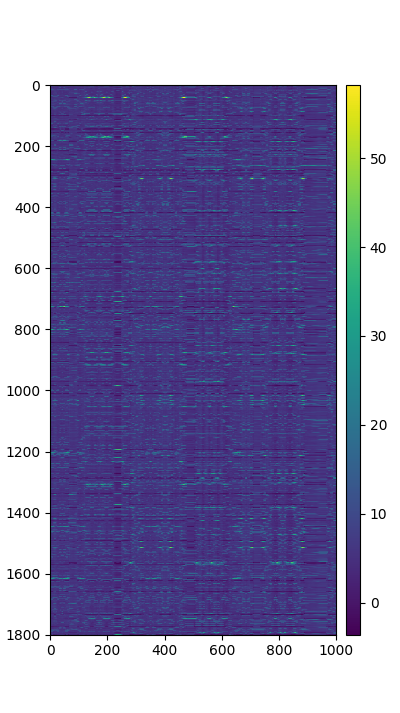

<IPython.core.display.Javascript object>


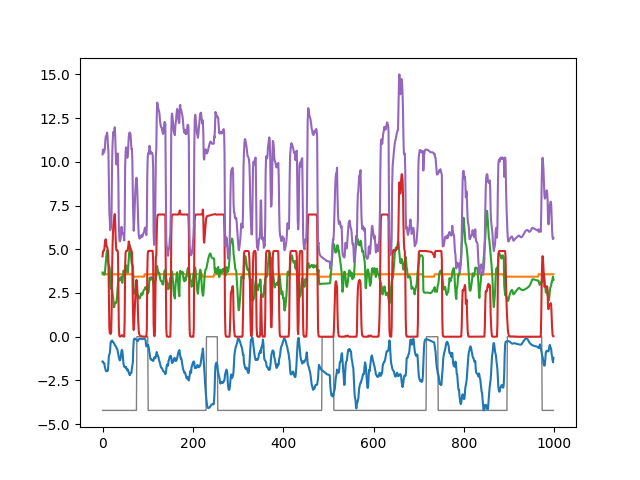

<IPython.core.display.Javascript object>


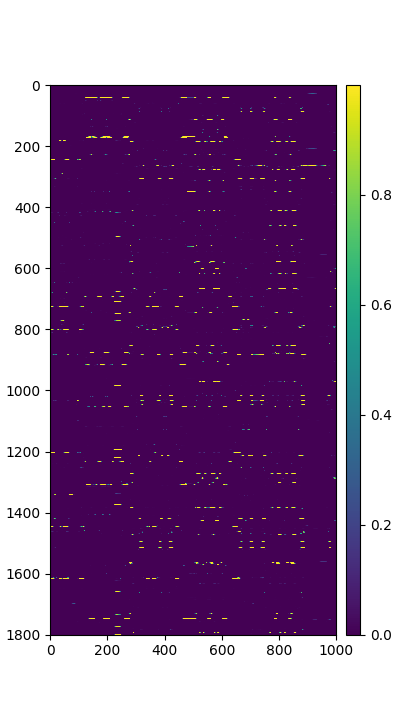

<IPython.core.display.Javascript object>


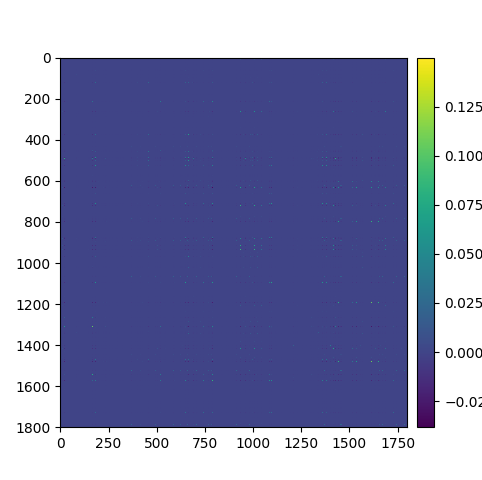

<IPython.core.display.Javascript object>


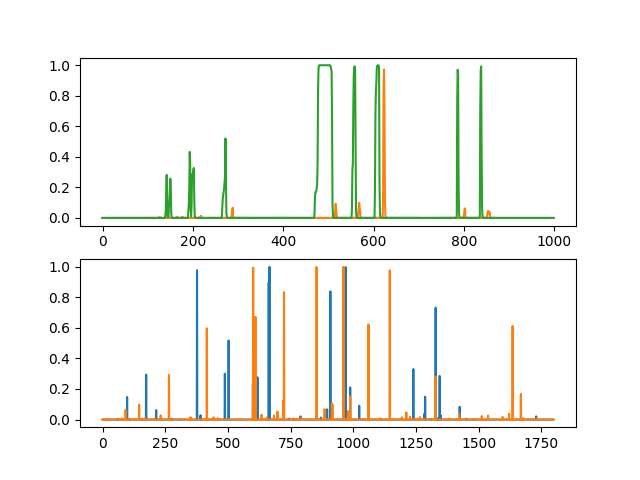

-1.54239 3.55077 3.25343 1.36711
Sparsity: 0.009636


In [350]:
start, stop = -1000, -1

R_FV = read_rates(outdir, 'FV', N_FV)[:, start:stop]
R_HD = read_rates(outdir, 'HD', N_HD)[:, start:stop]

H_PLACExFVxHD_INH = accumulate_activation(outdir, 'PLACExFVxHD', ['PLACExFVxHD'], N_PLACExFVxHD, slice(start, stop), INH=True) # 'HD'
H_PLACE_PLACExFVxHD = accumulate_activation(outdir, 'PLACExFVxHD', ['PLACE'], N_PLACExFVxHD, slice(start, stop))
H_FV_PLACExFVxHD = accumulate_activation(outdir, 'PLACExFVxHD', ['FV'], N_PLACExFVxHD, slice(start, stop))
H_HD_PLACExFVxHD = accumulate_activation(outdir, 'PLACExFVxHD', ['HD'], N_PLACExFVxHD, slice(start, stop))
H_PLACExFVxHD = H_PLACExFVxHD_INH + H_PLACE_PLACExFVxHD + H_HD_PLACExFVxHD + H_FV_PLACExFVxHD
imshow(H_PLACExFVxHD) #[W_idx_s])

# blue, orange, green, red, purple
fig, ax = plt.subplots()
j = 192
ax.plot(R_FV[0]*np.min(H_PLACExFVxHD_INH[j]), color='gray', lw=1)
ax.plot(H_PLACExFVxHD_INH[j])
ax.plot(H_FV_PLACExFVxHD[j])
ax.plot(H_HD_PLACExFVxHD[j])
ax.plot(H_PLACE_PLACExFVxHD[j])
ax.plot(H_PLACExFVxHD[j])

R_PLACExFVxHD = np.array(read_rates(outdir, 'PLACExFVxHD', N_PLACExFVxHD)[:, start:stop])
imshow(R_PLACExFVxHD) # [W_idx_s])
imshow(np.cov(R_PLACExFVxHD))
fig, ax = plt.subplots(2)
ax = ax.flatten()
ax[0].plot(R_PLACExFVxHD[W_idx_s[10]])
ax[0].plot(R_PLACExFVxHD[W_idx_s[250]])
ax[0].plot(R_PLACExFVxHD[W_idx_s[500]])
ax[1].plot(R_PLACExFVxHD[:, -1])
ax[1].plot(R_PLACExFVxHD[:, -17])

print(np.mean(H_PLACExFVxHD_INH), np.mean(H_FV_PLACExFVxHD), np.mean(H_HD_PLACExFVxHD), np.mean(H_PLACE_PLACExFVxHD))
print('Sparsity: %f' % (np.mean(np.sum(R_PLACExFVxHD, 0)) / N_PLACExFVxHD))

<IPython.core.display.Javascript object>


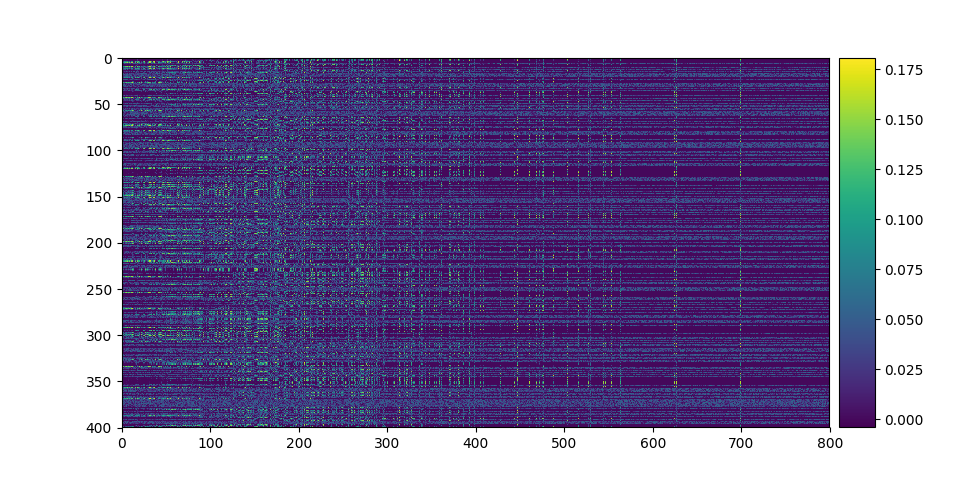

<IPython.core.display.Javascript object>


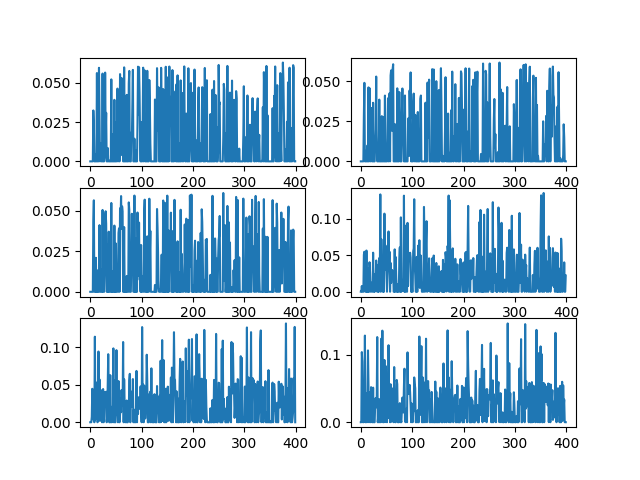

<IPython.core.display.Javascript object>


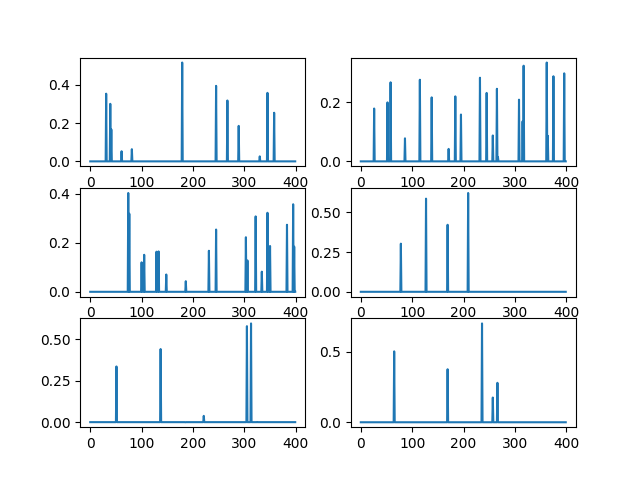

0.518552 1.0
0.757162 1.00012


In [17]:
W_AHVxHD_HD = read_weights(outdir, 'HD', 'AHVxHD', N_AHVxHD, N_HD)[-1]
W_HD_AHVxHD = read_weights(outdir, 'AHVxHD', 'HD', N_HD, N_AHVxHD)[-1] # - read_weights(outdir, 'AHVxHD', 'HD', 500, 1000)[0]
#W_idx = np.indices((W_AHVxHD_HD[-1].shape[0],))[0] + 1
W_idx_s = np.argsort(W_HD_AHVxHD @ HD_tuning) # np.sum(W_AHVxHD_HD[-1].T * W_idx, 1))[::-1]
W_idx_t = np.argsort(W_AHVxHD_HD @ W_HD_AHVxHD @ HD_tuning)

imshow(W_AHVxHD_HD[W_VIS_HD_idx][:, W_idx_s])# - W_AHVxHD_HD[0][:, W_idx_s])

fig, ax = plt.subplots(3,2)
ax = ax.flatten()
ax[0].plot(W_AHVxHD_HD[W_VIS_HD_idx, -10]) # .T[W_idx_s[10]]) # -W_AHVxHD_HD[0].T[W_idx_s[10]])
ax[1].plot(W_AHVxHD_HD[W_VIS_HD_idx, W_idx_s[-50]]) # .T[W_idx_s[50]]) # -W_AHVxHD_HD[0].T[W_idx_s[50]])
ax[2].plot(W_AHVxHD_HD[W_VIS_HD_idx, W_idx_s[-300]]) # .T[W_idx_s[300]]) # -W_AHVxHD_HD[0].T[W_idx_s[300]])
ax[3].plot(W_AHVxHD_HD[W_VIS_HD_idx, W_idx_s[-600]]) # .T[W_idx_s[600]]) # -W_AHVxHD_HD[0].T[W_idx_s[600]])
ax[4].plot(W_AHVxHD_HD[W_VIS_HD_idx, W_idx_s[50]]) # .T[W_idx_s[-50]]) # -W_AHVxHD_HD[0].T[W_idx_s[-50]])
ax[5].plot(W_AHVxHD_HD[W_VIS_HD_idx, 10]) # .T[W_idx_s[-10]]) # -W_AHVxHD_HD[0].T[W_idx_s[-10]])

fig, ax = plt.subplots(3,2)
ax = ax.flatten()
ax[0].plot(W_HD_AHVxHD[-10, W_VIS_HD_idx])
ax[1].plot(W_HD_AHVxHD[W_idx_s[-50], W_VIS_HD_idx])
ax[2].plot(W_HD_AHVxHD[W_idx_s[-300], W_VIS_HD_idx])
ax[3].plot(W_HD_AHVxHD[W_idx_s[-600], W_VIS_HD_idx])
ax[4].plot(W_HD_AHVxHD[W_idx_s[50], W_VIS_HD_idx])
ax[5].plot(W_HD_AHVxHD[10, W_VIS_HD_idx])

print(np.linalg.norm(W_AHVxHD_HD[:, -10]),
      np.linalg.norm(W_HD_AHVxHD[-10, :]))
print(np.linalg.norm(W_AHVxHD_HD[:, W_idx_s[1]]),
      np.linalg.norm(W_HD_AHVxHD[W_idx_s[1], :]))

#imshow(W_HD_AHVxHD)

<IPython.core.display.Javascript object>


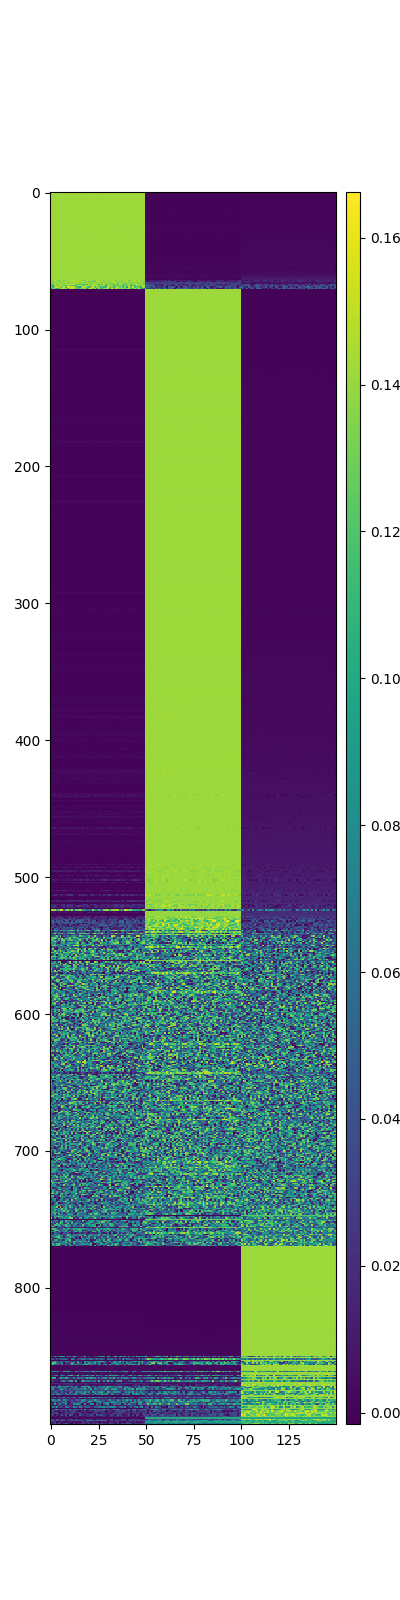

1.0
0.187291 0.575423 0.237286


In [153]:
W_AHV_AHVxHD = read_weights(outdir, 'AHVxHD', 'AHV', N_AHV, N_AHVxHD)[-1]
W_AHV_AHVxHD_cum = np.c_[np.sum(W_AHV_AHVxHD[:,:50], 1),
                         np.sum(W_AHV_AHVxHD[:,50:100], 1),
                         np.sum(W_AHV_AHVxHD[:,100:], 1)]
imshow(W_AHV_AHVxHD[np.argsort(W_AHV_AHVxHD_cum@np.array([25,75,125]))])
print(np.linalg.norm(W_AHV_AHVxHD[10]))
print(np.sum(W_AHV_AHVxHD[:,:50])/np.sum(W_AHV_AHVxHD),
      np.sum(W_AHV_AHVxHD[:,50:100])/np.sum(W_AHV_AHVxHD),
      np.sum(W_AHV_AHVxHD[:,100:])/np.sum(W_AHV_AHVxHD))

In [1201]:
W_VIS_HD = read_weights(outdir, 'HD', 'VIS', N_VIS, N_HD)[-1]
#W_VIS_HD[W_VIS_HD_idx] += np.fliplr(np.identity(N_HD) * 0.5)
W_VIS_HD.tofile('VIS/W_VIS_HD.bin')

W_AHVxHD_HD = read_weights(outdir, 'HD', 'AHVxHD', N_AHVxHD, N_HD)[-1]
#W_AHVxHD_HD = np.random.random(W_AHVxHD_HD.shape).astype(np.float32)
#W_AHVxHD_HD = scipy.sparse.rand(W_AHVxHD_HD.shape[0], W_AHVxHD_HD.shape[1], 0.4, dtype=np.float32).todense()
##N_REPLACE = 80
##W_tmp = W_AHVxHD_HD.copy()
##W_tmp[:, W_idx_s[-N_REPLACE:]] = (1+np.random.random((500, N_REPLACE)))/100
##W_tmp.tofile('W_AHVxHD_HD.bin')
W_AHVxHD_HD.tofile('VIS/W_AHVxHD_HD.bin')

W_HD_AHVxHD = read_weights(outdir, 'AHVxHD', 'HD', N_HD, N_AHVxHD)[-1]
#W_HD_AHVxHD = scipy.sparse.rand(W_HD_AHVxHD.shape[0], W_HD_AHVxHD.shape[1], 0.05, dtype=np.float32).todense()
##W_tmp = W_HD_AHVxHD.copy()
##W_tmp__ = W_HD_AHVxHD.copy()
##W_tmp[W_idx_s[-N_REPLACE:], :][W_tmp[W_idx_s[-N_REPLACE:], :] > 0] = 0.1
W_HD_AHVxHD.tofile('VIS/W_HD_AHVxHD.bin')

W_AHV_AHVxHD = read_weights(outdir, 'AHVxHD', 'AHV', N_AHV, N_AHVxHD)[-1]
W_AHV_AHVxHD.tofile('VIS/W_AHV_AHVxHD.bin')

#imshow(W_HD_AHVxHD)

In [404]:
plt.close('all')

<IPython.core.display.Javascript object>


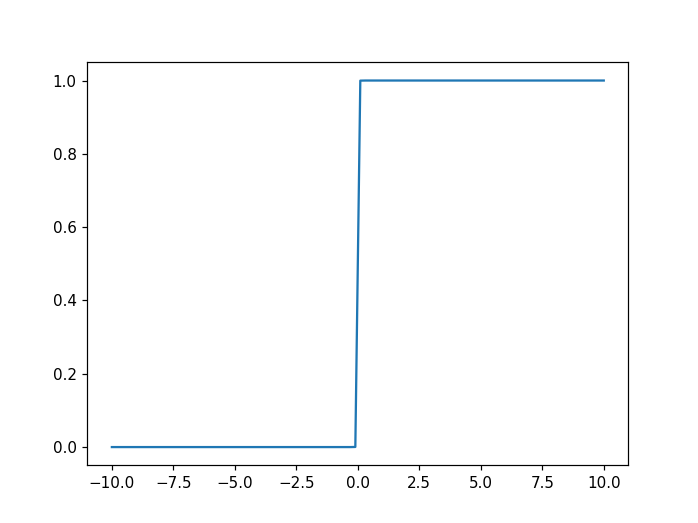

In [1495]:
fig, ax = plt.subplots()
X = np.linspace(-10, 10, 100)
ax.plot(X, 0.5*(np.tanh(40*X)+1))